In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyart
import matplotlib.pyplot as plt
from csu_radartools import csu_kdp
%matplotlib inline

In [2]:
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

In [3]:
def add_field_to_radar_object(field, radar, field_name='FH', units='unitless', 
                              long_name='Hydrometeor ID', standard_name='Hydrometeor ID',
                              dz_field='reflectivity'):
    """
    Adds a newly created field to the Py-ART radar object. If reflectivity is a masked array,
    make the new field masked the same as reflectivity.
    """
    fill_value = -32768
    masked_field = np.ma.asanyarray(field)
    masked_field.mask = masked_field == fill_value
    if hasattr(radar.fields[dz_field]['data'], 'mask'):
        setattr(masked_field, 'mask', 
                np.logical_or(masked_field.mask, radar.fields[dz_field]['data'].mask))
        fill_value = radar.fields[dz_field]['_FillValue']
    field_dict = {'data': masked_field,
                  'units': units,
                  'long_name': long_name,
                  'standard_name': standard_name,
                  '_FillValue': fill_value}
    radar.add_field(field_name, field_dict, replace_existing=True)
    return radar

def extract_unmasked_data(radar, field, bad=-32768):
    """Simplify getting unmasked radar fields from Py-ART"""
    return radar.fields[field]['data'].filled(fill_value=bad)

def interpolate_radially(radar, field, start_gate, end_gate, units='mmh-1',
                         long_name='Interpolated Rain', standard_name='Interpolated Rain'):
    rain = radar.fields[field]['data']
    sweep_starts = np.append(radar.sweep_start_ray_index['data'], None)

    def func(a):
        x=np.arange(720)
        y=a.data
        ma=a.mask
        y[ma] = np.interp(x[ma], x[~ma], y[~ma], left=0, right=0)

    for n in range(len(sweep_starts)-1):
        foo = [func(rain[sweep_starts[n]:sweep_starts[n+1],i]) for i in range(start_gate, end_gate)]
    
    radar = add_field_to_radar_object(rain.data, radar, 'interpolated_'+field, units=units, dz_field=dz_field,
                                      long_name=long_name, standard_name=standard_name)

    radar.fields['interpolated_'+field]['data'].mask=False
    return radar

def extract_unmasked_data(radar, field, bad=-32768):
    """Simplify getting unmasked radar fields from Py-ART"""
    return radar.fields[field]['data'].filled(fill_value=bad)

def calculate_kdp(radar):
    
    dz = extract_unmasked_data(radar, 'reflectivity')
    dr = extract_unmasked_data(radar, 'differential_reflectivity')
    dp = extract_unmasked_data(radar, 'differential_phase')
    rh = extract_unmasked_data(radar, 'cross_correlation_ratio')

    # Range needs to be supplied as a variable, and it needs to be the same shape as dzN, etc.
    rng2d, az2d = np.meshgrid(radar.range['data'], radar.azimuth['data'])

    gs = rng2d[0,1] - rng2d[0,0]
    kd, fd, sd = csu_kdp.calc_kdp_bringi(dp=dp, dz=dz, rng=rng2d/1000.0, thsd=12, gs=gs, window=3)
    radar = add_field_to_radar_object(kd, radar, field_name='KDP', units='deg/km', 
                                       long_name='Specific Differential Phase',
                                       standard_name='Specific Differential Phase', 
                                       dz_field='reflectivity')
    radar = add_field_to_radar_object(fd, radar, field_name='FDP', units='deg', 
                                       long_name='Filtered Differential Phase',
                                       standard_name='Filtered Differential Phase', 
                                       dz_field='reflectivity')
    radar = add_field_to_radar_object(sd, radar, field_name='SDP', units='deg', 
                                       long_name='Standard Deviation of Differential Phase',
                                       standard_name='Standard Deviation of Differential Phase', 
                                       dz_field='reflectivity')
    return radar

def plot_base_scan(radar, sweep, field, ax, cbar=False, title='time', **kwargs):
    base_time = pd.Timestamp(radar.time['units'].split()[2])
    sweep_time = pd.Timedelta(seconds=radar.time['data'][(radar.get_start(sweep)+
                                                          radar.get_end(sweep))/2])+base_time

    ds0 = ds.where((ds.cloud_ground == b'G') &
                   ((sweep_time-pd.Timedelta(minutes=1)).asm8<ds.time) &
                   (ds.time<(sweep_time+pd.Timedelta(minutes=1)).asm8) &
                   (min_lat<ds.lat) & (ds.lat<max_lat) &
                   (min_lon<ds.lon) & (ds.lon<max_lon)
                  ).dropna('record')
    extents.update(kwargs)
    if title=='time':
        title=sweep_time.round('s')
    elif title=='field':
        title=field
    display_map = pyart.graph.RadarMapDisplay(radar)
    display_map.plot_ppi_map(field, sweep, title=title, colorbar_flag=False,
                             ax=ax, resolution='l', **extents)
    display_map.plot_point(ds0.lon.values, ds0.lat.values, symbol='w+', ms=10, mew=2)
    if cbar:
        fig.colorbar(display_map.plots[-1], ax=ax)

In [4]:
radar0 = pyart.io.read("data/KICX20150914_221837_V06.gz")
radar1 = pyart.io.read("data/KICX20150914_222306_V06.gz")

radar0 = calculate_kdp(radar0)
radar1 = calculate_kdp(radar1)

radar0.fields.keys()

['SDP',
 'differential_phase',
 'cross_correlation_ratio',
 'spectrum_width',
 'reflectivity',
 'FDP',
 'differential_reflectivity',
 'velocity',
 'KDP']

In [5]:
ds = xr.open_dataset("data/2015_09_14.nc")

In [6]:
min_lat=36.85
max_lat=37.06
min_lon=-113.2
max_lon=-112.8
extents = dict(min_lat=min_lat, max_lat=max_lat, min_lon=min_lon, max_lon=max_lon)

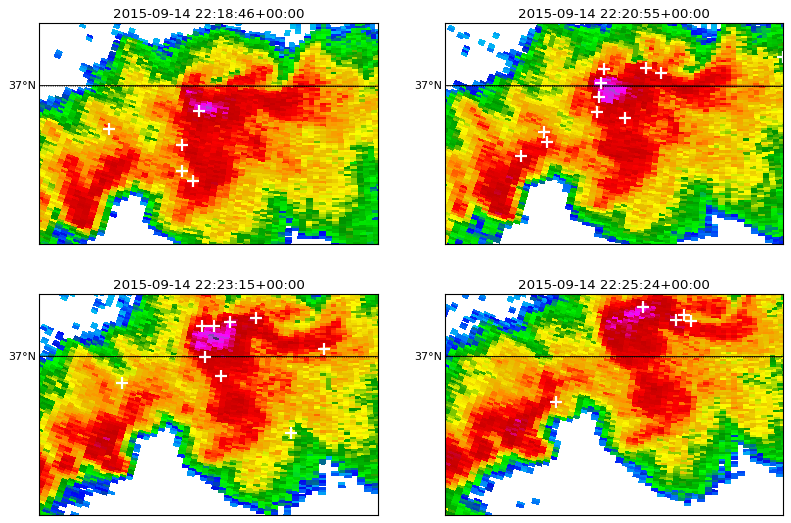

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
    
plot_base_scan(radar0, 0, 'reflectivity', axes[0,0], vmin=-8, vmax=75)
plot_base_scan(radar0, 8, 'reflectivity', axes[0,1], vmin=-8, vmax=75)
plot_base_scan(radar1, 0, 'reflectivity', axes[1,0], vmin=-8, vmax=75)
plot_base_scan(radar1, 8, 'reflectivity', axes[1,1], vmin=-8, vmax=75)

plt.savefig('./Figures/Fig 1. Base scan reflectivity with CG flashes.png')

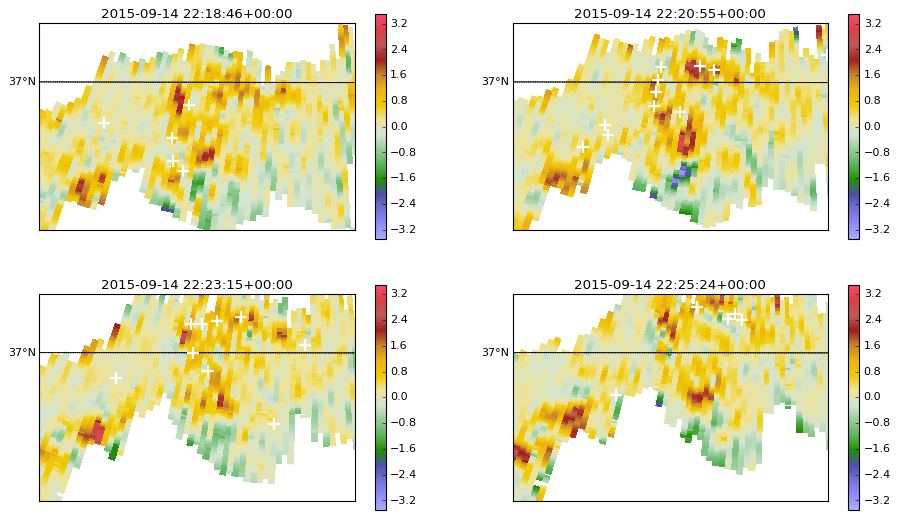

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,8))

plot_base_scan(radar0, 0, 'KDP', axes[0,0], cmap='pyart_Theodore16', vmin=-3.5, vmax=3.5, cbar=True)
plot_base_scan(radar0, 8, 'KDP', axes[0,1], cmap='pyart_Theodore16', cbar=True)
plot_base_scan(radar1, 0, 'KDP', axes[1,0], cmap='pyart_Theodore16', cbar=True)
plot_base_scan(radar1, 8, 'KDP', axes[1,1], cmap='pyart_Theodore16', cbar=True)
plt.savefig('./Figures/Fig 1.5 Base scan KDP with CG flashes.png')

In [9]:
min_lat=36.95
max_lat=37.06
min_lon=-113.1
max_lon=-112.9
extents = dict(min_lat=min_lat, max_lat=max_lat, min_lon=min_lon, max_lon=max_lon)

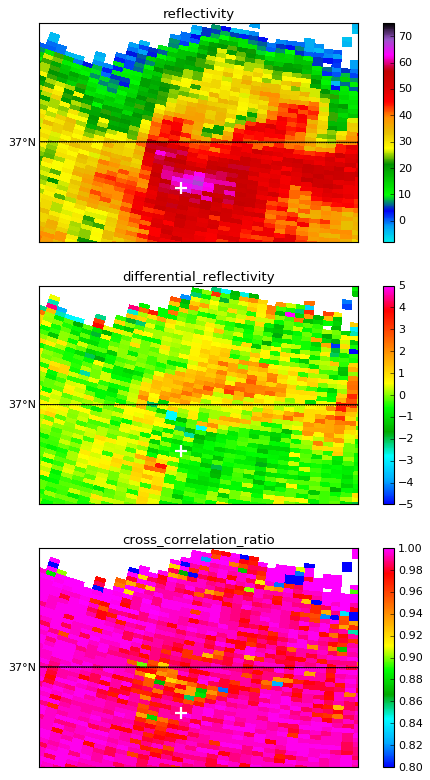

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8,12))
plot_base_scan(radar0, 0, 'reflectivity', axes[0], 
               title='field', cbar=True, vmin=-8, vmax=75)
plot_base_scan(radar0, 0, 'differential_reflectivity', axes[1], 
               title='field', cbar=True, vmin=-5, vmax=5)
plot_base_scan(radar0, 0, 'cross_correlation_ratio', axes[2], 
               title='field', cbar=True, vmin=0.8, vmax=1)
plt.savefig('./Figures/Fig 2. UTC 22:18 with CG flashes.png')

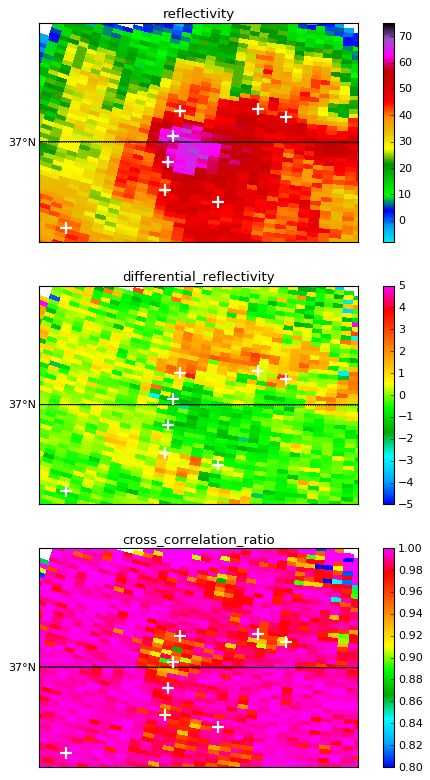

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8,12))
extents = dict(min_lat=min_lat, max_lat=max_lat, min_lon=min_lon, max_lon=max_lon)
plot_base_scan(radar0, 8, 'reflectivity', axes[0], 
               title='field', cbar=True, vmin=-8, vmax=75)
plot_base_scan(radar0, 8, 'differential_reflectivity', axes[1], 
               title='field', cbar=True, vmin=-5, vmax=5)
plot_base_scan(radar0, 8, 'cross_correlation_ratio', axes[2], 
               title='field', cbar=True, vmin=0.8, vmax=1)
plt.savefig('./Figures/Fig 3. UTC 22:20 with CG flashes.png')

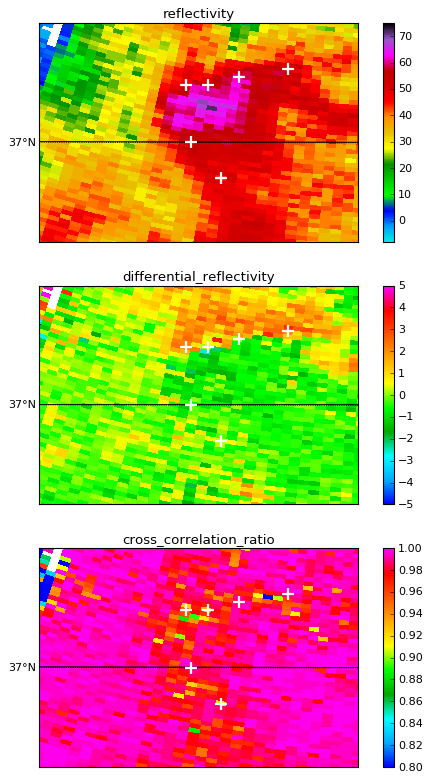

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8,12))
plot_base_scan(radar1, 0, 'reflectivity', axes[0], 
               title='field', cbar=True, vmin=-8, vmax=75)
plot_base_scan(radar1, 0, 'differential_reflectivity', axes[1], 
               title='field', cbar=True, vmin=-5, vmax=5)
plot_base_scan(radar1, 0, 'cross_correlation_ratio', axes[2], 
               title='field', cbar=True, vmin=0.8, vmax=1)
plt.savefig('./Figures/Fig 4. UTC 22:23 with CG flashes.png')

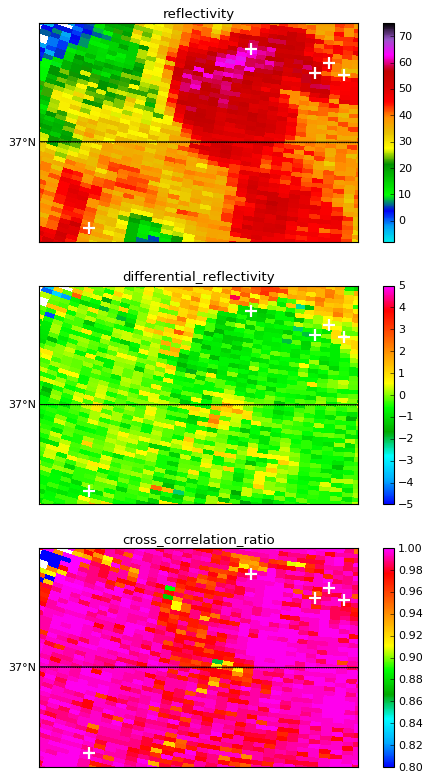

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8,12))
plot_base_scan(radar1, 8, 'reflectivity', axes[0], 
               title='field', cbar=True, vmin=-8, vmax=75)
plot_base_scan(radar1, 8, 'differential_reflectivity', axes[1], 
               title='field', cbar=True, vmin=-5, vmax=5)
plot_base_scan(radar1, 8, 'cross_correlation_ratio', axes[2], 
               title='field', cbar=True, vmin=0.8, vmax=1)
plt.savefig('./Figures/Fig 5. UTC 22:25 with CG flashes.png')